In [362]:
import numpy as np
import qutip as qt

import numpy as np
from qutip import Options
import qutip as qt
from qutip import ket2dm
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm
import cmath
from scipy.optimize import curve_fit

In [429]:
max_fid = []
lambda_power = []

In [430]:
# build the four qubit system
qubit_dim = 2

w1_un = 4
w2_un = 6
w3_un = 4.000001
w4_un = 5.999999
ws_un = 6 - (1 / 3) * (1 / 2)


qubit1 = QubitMode(
    name="q1", dim=2, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    name="q2", dim=2, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    name="q3", dim=2, freq=w3_un, alpha=-0.160, T1=1e2, T2=5e1
)
qubit4 = QubitMode(
    name="q4", dim=2, freq=w4_un, alpha=-0.159, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3, qubit4]
snail = SNAILMode(name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    frozenset([qubit3, snail]): 2 * np.pi * 0.04875,
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

In [431]:
# important multipliers and hamiltonian prefactors 
l1 = l2 = l3 = .1

w1 = qubit1.freq / (2 * np.pi) 
w2 = qubit2.freq / (2 * np.pi) 
w3 = qubit3.freq / (2 * np.pi)  
w4 = qubit4.freq / (2 * np.pi) 
ws = snail.freq / (2 * np.pi)

# time over which to optimize
T = 100

#pump(drive) frequency
# wp = w1 - w2
wp = w2 - w1

In [432]:
# unchanged terms of hamiltonian
H_no_time = 6*(l1**2)*(qs.modes_a[qubit1]*qs.modes_a_dag[qubit2] + qs.modes_a[qubit2]*qs.modes_a_dag[qubit1])

#terms that come from the gate that is desired that do not go to one
qubit1_qubit2_adj_H = 6*(l1**2)*qs.modes_a[qubit1]*qs.modes_a_dag[qubit2]
qubit1_adj_qubit2_H = 6*(l1**2)*qs.modes_a[qubit2]*qs.modes_a_dag[qubit1]

H_main_qubits = [
H_no_time,
qubit1_qubit2_adj_H,
qubit1_adj_qubit2_H
]


In [433]:
# cell that will determine over which lambda power to evaluate

qubit3_qubit2_adj_H = qs.modes_a[qubit3]*qs.modes_a_dag[qubit2]
qubit3_adj_qubit2_H = qs.modes_a[qubit2]*qs.modes_a_dag[qubit3]
qubit4_qubit2_adj_H = qs.modes_a[qubit4]*qs.modes_a_dag[qubit2]
qubit4_adj_qubit2_H = qs.modes_a[qubit2]*qs.modes_a_dag[qubit4]
qubit3_qubit1_adj_H = qs.modes_a[qubit3]*qs.modes_a_dag[qubit1]
qubit3_adj_qubit1_H = qs.modes_a[qubit1]*qs.modes_a_dag[qubit3]
qubit4_qubit1_adj_H = qs.modes_a[qubit4]*qs.modes_a_dag[qubit1]
qubit4_adj_qubit1_H = qs.modes_a[qubit1]*qs.modes_a_dag[qubit4]

H_added = [
qubit3_qubit2_adj_H,
qubit3_adj_qubit2_H,
qubit4_qubit2_adj_H,
qubit4_adj_qubit2_H,
qubit3_qubit1_adj_H,
qubit3_adj_qubit1_H,
qubit4_qubit1_adj_H,
qubit4_adj_qubit1_H
]


In [462]:
H_modified = []
def choose_lambda(choice):
    for i in range(len(H_added)):
        if(choice == 2):
            H_modified.append(6 * (l1**2) * H_added[i])
        elif(choice == 3):
            H_modified.append(6 * (l1**3) * H_added[i])
        elif(choice == 4):
            H_modified.append(6 * (l1**4) * H_added[i])
        elif(choice == 5):
            H_modified.append(6 * (l1**5) * H_added[i])
        elif(choice == 6):
            H_modified.append(6 * (l1**6) * H_added[i])

    return H_modified


# combine all of the hamiltonian terms into one list
H_total = []
H_total.extend(H_main_qubits)
# call in the function 
choice = 6
H_mod = choose_lambda(choice)
lambda_power.append(choice)
H_total.extend(H_mod)

In [463]:
# build the pulses for the unitary 
def int_func(w1,w2,wp,t):
    a=((np.exp(-1j*(w1-w2+wp)*t))/(-1j*(w1-w2+wp)) - (1/(-1j*(w1-w2+wp))))
    return a

def int_func_conj_wp(w1,w2,wp,t):
     a = ((np.exp(-1j*(w1-w2-wp)*t))/(-1j*(w1-w2-wp)) - (1/(-1j*(w1-w2-wp))))
     return a

def int_func_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2+wp)*t))/(1j*(w1-w2+wp)) - (1/(1j*(w1-w2+wp))))
    return a 

def int_func_conj_wp_conj(w1,w2,wp,t):
    a = ((np.exp(1j*(w1-w2-wp)*t))/(1j*(w1-w2-wp)) - (1/(1j*(w1-w2-wp))))
    return a

T = 100

qubit1_qubit2_adj_val = int_func_conj_wp(w1,w2,wp,T)
qubit1_adj_qubit2_val = int_func_conj_wp_conj(w1,w2,wp,T)
qubit1_qubit3_adj_val = int_func(w1,w3,wp,T) + int_func_conj_wp(w1,w3,wp,T)
qubit2_qubit3_adj_val = int_func(w2,w3,wp,T) + int_func_conj_wp(w2,w3,wp,T)
qubit1_adj_qubit3_val = int_func(w3,w1,wp,T) + int_func_conj_wp(w3,w1,wp,T)
qubit2_adj_qubit3_val = int_func(w3,w2,wp,T) + int_func_conj_wp(w3,w2,wp,T)
qubit1_qubit4_adj_val = int_func(w1,w4,wp,T) + int_func_conj_wp(w1,w4,wp,T)
qubit2_qubit4_adj_val = int_func(w2,w4,wp,T) + int_func_conj_wp(w2,w4,wp,T)
qubit1_adj_qubit4_val = int_func(w4,w1,wp,T) + int_func_conj_wp(w4,w1,wp,T)
qubit2_adj_qubit4_val = int_func(w4,w2,wp,T) + int_func_conj_wp(w4,w2,wp,T)

# building the time_multiplier list 
T_mult = [
T,
qubit1_qubit2_adj_val,
qubit1_adj_qubit2_val,
qubit2_adj_qubit3_val,
qubit2_qubit3_adj_val,
qubit2_adj_qubit4_val,
qubit2_qubit4_adj_val,
qubit1_adj_qubit3_val,
qubit1_qubit3_adj_val,
qubit1_adj_qubit4_val,
qubit1_qubit4_adj_val
]

In [464]:
# determine the amount of modules in the system 
# takes care of the hamiltonian terms and the pulse terms 
def mod_amount(count):
    H_tot = []
    ts = []
    ts.append(T_mult[0])
    ts.append(T_mult[1])
    ts.append(T_mult[2])
    H_tot.extend(H_main_qubits)
    for j in range(count):
        for i in range(3,len(H_total)):
            H_tot.append(H_total[i])
            ts.append(T_mult[i])

    return [H_tot, ts]

res = mod_amount(1)

In [465]:
# extract out the hamiltonian and the time multiplier from the mod count results 
multiplier_times = res[1]
H = res[0]

In [466]:
# build the desired unitary 
# U_targ = U = qt.tensor(qt.qip.operations.iswap(N=2),qt.qeye(2),qt.identity(cavity.dim))
desired_U = qt.qip.operations.iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
for mode in qs.modes[2:]:  # Skip the first two qubits as they're already included
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2

In [467]:
# build the designed unitary
# run the fidelity analysis over the expected gate 
amps = np.linspace(0,8,100)
results = []
fids = []

for i in amps:
    eta = ((2 * wp) / ((wp**2) - (ws**2))) * i
    Z = []
    for j in range(len(H)):
        
        Z.append(eta * H[j] * multiplier_times[j])

    w = sum(Z)
    U_propagator = (-1j * w).expm()

    #calculate the fidelity
    fid = np.abs(qt.average_gate_fidelity(desired_U, U_propagator))
    results.append([i,fid])
    fids.append(fid)


In [468]:
# extract the highest fidelity observed 
max_fid.append(max(fids))
max(fids)

0.9997064884877738

Text(0, 0.5, 'max fidelity achieved')

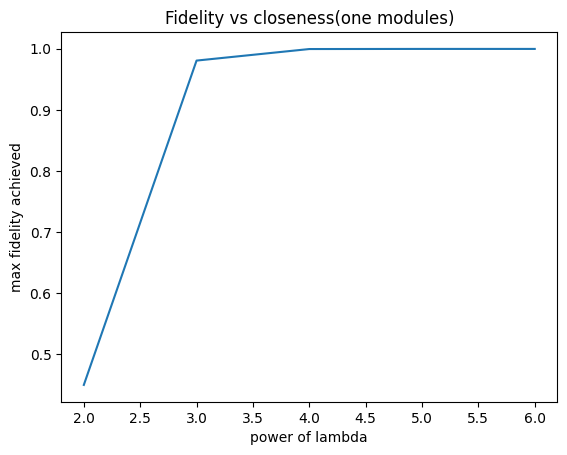

In [470]:
# plot of max fidelity vs power of lambda
fig, ax = plt.subplots()
ax.plot(lambda_power,max_fid)
ax.set_title("Fidelity vs closeness(one modules)")
ax.set_xlabel("power of lambda")
ax.set_ylabel("max fidelity achieved")
